In [1]:
#  The code is open source and intended for educational and scientific
#  purposes only.
#
#  Disclaimer:
#  The authors reserve all rights but do not guarantee that the code is
#  free from errors. Furthermore, the authors shall not be liable in any
#  event caused by the use of the program.
#######################################################

In [2]:
import abc
import copy
from typing import Callable, Dict, Optional, Sequence, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
from numpy.polynomial import hermite_e, legendre
from scipy import linalg, optimize, stats

NDArray = npt.NDArray[np.float_]

In [3]:
%matplotlib inline

# Some conventions

* UPPERCASE VARIABLES are assumed to be constant / immutable.
* The sample index is always first. If `s` is an array representing a sample of size `N`, its shape will be `(N,...)`. 
* Most functions will accept a sample and work sample-wise, meaning that if `s` is a sample, `f(s)` is likely another sample such that `f(s)[i] = f(s[i])`.
* The counterparts of the previous remark are that

  * Sometimes a dummy dimension must be added, such that we get a sample of shape `(1,...)`,
  * The evaluation of `f` on a single element will output a sample of size 1, i.e. the shape of `f(s[i])` will have a shape of size `(1,...)`. In order to remove the first dimension, one can either use `f(s[i]).squeeze(axis=0)`, `np.squeeze(f(s[i]), axis=0)`, or `f(s[i])[0]`.

# Data exploration

We load the simulation results included in the `data.npz` archive.
The data related to the tensile and shear tests are stored in the `RAW_DATA` dictionary.

In the following, 

* the variable `X` is an array of shape `(5000, 5)` that contains the sample of material parameters.
* the tuple `PARAMETER_NAMES` contains the name of the material parameter associated to each column of `X`.
* the variable `Y` is an array of shape `(5000, 42)` that contains the sample of simulated stresses.
* the variable `Y_TRUE` is an array of shape `(42,)` that contains a single sample of stresses that will be used at the end of the course.


In [37]:
npz_path = "/home/lg265056/workspace/uqmaterialparam/data/preprocessed/data.npz"
RAW_DATA = np.load(npz_path)
X = RAW_DATA["x"]
PARAMETER_NAMES = "young_modulus", "poisson_ratio", "yield_strength", "alpha", "n"
Y = RAW_DATA["y"]
Y_TRUE = RAW_DATA["y_true"]

## X transformation

The `X` sample cannot be directly used for the construction of the polynomial chaos expansion. We first need to map the columns of `X` to some reference distributions, in particular $\mathcal{N}(0,1)$ and $\mathcal{U}(-1, 1)$ in our case.

It is supposed that the material parameters are distributed according to
$$
E \sim \log-\mathcal{N}(E_\mu, E_\sigma),\\
\nu \sim \log-\mathcal{N}(\nu_\mu, \nu_\sigma),\\
\sigma_0 \sim \mathcal{U}(150e6, 250e6),\\
\alpha \sim \mathcal{U}(0.5, 3.0),\\
n \sim \mathcal{U}(5, 15).
$$

The log-normal distribution $\log-\mathcal{N}$ ensures that the associated random variables are positive.
Indeed, $E \sim \log-\mathcal{N}(E_\mu, E_\sigma)$ means that $E$ can be written
$$
E = \exp\left(E_\mu + E_\sigma Z\right), \quad \text{where} \quad Z \sim \mathcal{N}(0, 1).
$$

In [38]:
def lognormal_moments_to_parameters(mean: float, std: float) -> Tuple[float, float]:
    # If X is log-normal, transform the expectation and standard deviation of X to X_mu and X_sigma
    mu = np.log(mean**2 / np.sqrt(mean**2 + std**2))
    sigma = np.sqrt(np.log(1 + (std / mean) ** 2))
    return mu, sigma


YOUNG_MODULUS_MEAN = 70e9
YOUNG_MODULUS_STD = 15e9
YOUNG_MODULUS_MU, YOUNG_MODULUS_SIGMA = lognormal_moments_to_parameters(
    YOUNG_MODULUS_MEAN, YOUNG_MODULUS_STD
)

POISSON_RATIO_MEAN = 0.3
POISSON_RATIO_STD = 0.03
POISSON_RATIO_MU, POISSON_RATIO_SIGMA = lognormal_moments_to_parameters(
    POISSON_RATIO_MEAN, POISSON_RATIO_STD
)

YIELD_STRENGTH_LOW = 150e6
YIELD_STRENGTH_HIGH = 250e6

ALPHA_LOW = 0.5
ALPHA_HIGH = 3.0

N_LOW = 5
N_HIGH = 15


X_DISTRIBUTIONS = {
    "young_modulus": stats.lognorm(
        s=YOUNG_MODULUS_SIGMA, scale=np.exp(YOUNG_MODULUS_MU)
    ),
    "poisson_ratio": stats.lognorm(
        s=POISSON_RATIO_SIGMA, scale=np.exp(POISSON_RATIO_MU)
    ),
    "yield_strength": stats.uniform(
        loc=YIELD_STRENGTH_LOW, scale=YIELD_STRENGTH_HIGH - YIELD_STRENGTH_LOW
    ),
    "alpha": stats.uniform(loc=ALPHA_LOW, scale=ALPHA_HIGH - ALPHA_LOW),
    "n": stats.uniform(loc=N_LOW, scale=N_HIGH - N_LOW),
}

We need now to map the material parameters to the reference distributions $\mathcal{N}(0,1)$ and $\mathcal{U}(-1, 1)$. These probability distributions are suitable for Hermite and Legendre polynomials respectively.

The transforms between the physical space (`X`) and the latent / reference space (`Z`) are stored in some helper functions.
For the rest of the course, the sample of material parameters in the reference space is stored in the `Z` variable.

In [39]:
def x2z(x: NDArray) -> NDArray:
    x_ = np.atleast_2d(x)
    z = np.empty_like(x_)
    z[:, 0] = (np.log(x_[:, 0]) - YOUNG_MODULUS_MU) / YOUNG_MODULUS_SIGMA
    z[:, 1] = (np.log(x_[:, 1]) - POISSON_RATIO_MU) / POISSON_RATIO_SIGMA
    z[:, 2] = (
        2 * (x_[:, 2] - YIELD_STRENGTH_LOW) / (YIELD_STRENGTH_HIGH - YIELD_STRENGTH_LOW)
        - 1
    )
    z[:, 3] = 2 * (x_[:, 3] - ALPHA_LOW) / (ALPHA_HIGH - ALPHA_LOW) - 1
    z[:, 4] = 2 * (x_[:, 4] - N_LOW) / (N_HIGH - N_LOW) - 1
    return z


def z2x(z: NDArray) -> NDArray:
    z_ = np.atleast_2d(z)
    x = np.empty_like(z_)
    x[:, 0] = np.exp(YOUNG_MODULUS_MU + YOUNG_MODULUS_SIGMA * z_[:, 0])
    x[:, 1] = np.exp(POISSON_RATIO_MU + POISSON_RATIO_SIGMA * z_[:, 1])
    a = 0.5 * (YIELD_STRENGTH_HIGH - YIELD_STRENGTH_LOW)
    b = 0.5 * (YIELD_STRENGTH_HIGH + YIELD_STRENGTH_LOW)
    x[:, 2] = a * z_[:, 2] + b
    a = 0.5 * (ALPHA_HIGH - ALPHA_LOW)
    b = 0.5 * (ALPHA_HIGH + ALPHA_LOW)
    x[:, 3] = a * z_[:, 3] + b
    a = 0.5 * (N_HIGH - N_LOW)
    b = 0.5 * (N_HIGH + N_LOW)
    x[:, 4] = a * z_[:, 4] + b
    return x


Z_DISTRIBUTIONS = {
    "young_modulus": stats.norm(),
    "poisson_ratio": stats.norm(),
    "yield_strength": stats.uniform(loc=-1, scale=2),
    "alpha": stats.uniform(loc=-1, scale=2),
    "n": stats.uniform(loc=-1, scale=2),
}

Z = x2z(X)

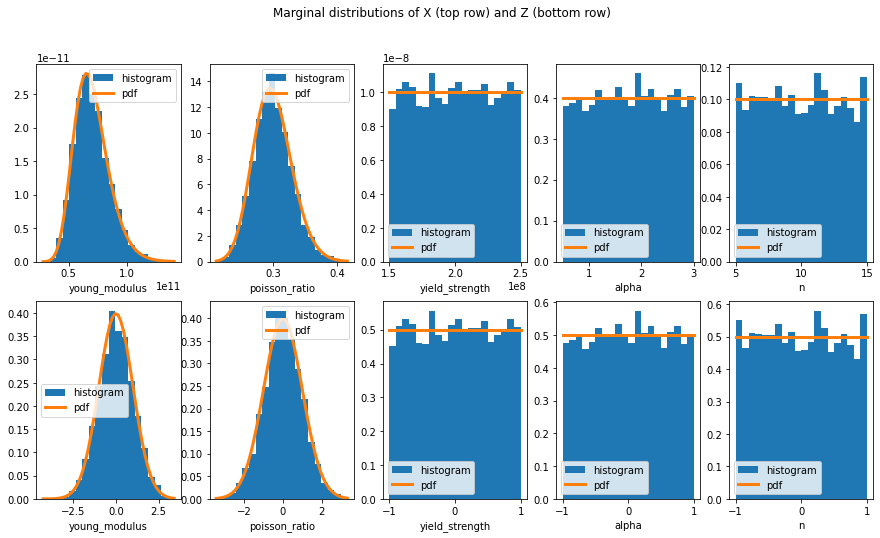

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 8))
fig.suptitle("Marginal distributions of X (top row) and Z (bottom row)")

for i, p in enumerate(PARAMETER_NAMES):
    x_min = X[:, i].min()
    x_max = X[:, i].max()
    x = np.linspace(x_min, x_max)
    x_pdf = X_DISTRIBUTIONS[p].pdf(x)

    axes[0, i].hist(X[:, i], bins=20, density=True, label="histogram")
    axes[0, i].plot(x, x_pdf, linewidth=3, label="pdf")
    axes[0, i].legend()
    axes[0, i].set_xlabel(p)

    z_min = Z[:, i].min()
    z_max = Z[:, i].max()
    z = np.linspace(z_min, z_max)
    z_pdf = Z_DISTRIBUTIONS[p].pdf(z)

    axes[1, i].hist(Z[:, i], bins=20, density=True, label="histogram")
    axes[1, i].plot(z, z_pdf, linewidth=3, label="pdf")
    axes[1, i].legend()
    axes[1, i].set_xlabel(p)

## Y exploration

This section introduces a useful helper function, namely `extract_strain_stresses`. This function takes a realization `y` of the output `Y`, and returns the strain, the tensile stress and the shear stress. Note that the imposed strains for the two tests share the same values.

Text(0, 0.5, '$\\sigma_{xy}$')

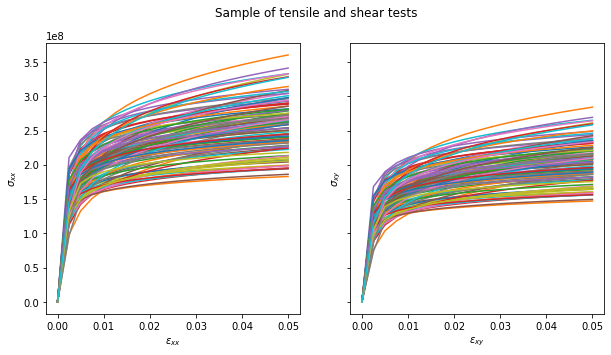

In [41]:
def extract_strain_stresses(y: NDArray) -> tuple[NDArray, NDArray, NDArray]:
    num_strain_steps = 21
    strain_min = 0.0
    strain_max = 0.05
    strain = np.linspace(strain_min, strain_max, num_strain_steps)

    tensile_stress = y[:num_strain_steps]
    shear_stress = y[num_strain_steps:]
    return strain, tensile_stress, shear_stress


num_curves = 100
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(10, 5))
fig.suptitle("Sample of tensile and shear tests")

for _ in range(num_curves):
    sample_id = np.random.randint(low=0, high=len(Y))
    y = Y[sample_id]
    strain, tensile_stress, shear_stress = extract_strain_stresses(y)

    axes[0].plot(strain, tensile_stress)
    axes[1].plot(strain, shear_stress)

axes[0].set_xlabel(r"$\varepsilon_{xx}$")
axes[0].set_ylabel(r"$\sigma_{xx}$")
axes[1].set_xlabel(r"$\varepsilon_{xy}$")
axes[1].set_ylabel(r"$\sigma_{xy}$")

# Polynomial chaos expansion

In order to build a truncated polynomial chaos expansion for approximating the $Y$ random vector, we need the implementation of the univariate polynomial bases. In this course, we are only interested in Hermite $(H_n)_{n\in\mathbb{N}}$ and Legendre $(L_n)_{n\in\mathbb{N}}$ polynomials that are orthogonal with respect to the probability density functions associated to the standard normal distribution, and the uniform distribution respectively.

In particular, the Hermite and the Legendre polynomials satisfy the relations
$$
\mathbb{E}\left(H_m(Z)H_n(Z)\right) = \int_{\mathbb{R}} H_m(z) H_n(z) p_Z(z) dz = m! \delta_{mn}, \quad \text{where} \quad Z \sim \mathcal{N}(0,1),
$$
and
$$
\mathbb{E}\left(L_m(Z)L_n(Z)\right) = \int_{-1}^1 L_m(z) L_n(z) p_Z(z) dz = \frac{1}{2m+1} \delta_{mn}, \quad \text{where} \quad Z \sim \mathcal{U}(-1,1).
$$

## Univariate polynomials

In [9]:
class UnivariatePC(abc.ABC):
    def __init__(self, deg: int) -> None:
        self.deg = deg

    @abc.abstractmethod
    def __call__(self, z: NDArray) -> NDArray:
        pass

    @abc.abstractmethod
    def grad(self, z: NDArray) -> NDArray:
        pass

    @abc.abstractmethod
    def sample_z(self, sample_size: int) -> NDArray:
        pass

    def sample(self, sample_size: int) -> NDArray:
        return self(self.sample_z(sample_size))

    @abc.abstractmethod
    def square_norm(self) -> NDArray:
        pass

    def norm(self) -> NDArray:
        return np.sqrt(self.square_norm())


class HermitePC(UnivariatePC):
    def __repr__(self) -> str:
        return f"HermitePC({self.deg})"

    def __call__(self, z: NDArray) -> NDArray:
        return hermite_e.hermevander(z, self.deg)

    def grad(self, z: NDArray) -> NDArray:
        phi = self(z)
        grad_phi = np.empty_like(phi)
        grad_phi[:, 0] = 0
        for d in range(1, self.deg + 1):
            grad_phi[:, d] = d * phi[:, d - 1]
        return grad_phi

    def sample_z(self, sample_size: int) -> NDArray:
        return stats.norm.rvs(size=sample_size)

    def square_norm(self) -> NDArray:
        return np.array(
            [np.math.factorial(d) for d in range(self.deg + 1)], dtype=float
        )


class LegendrePC(UnivariatePC):
    def __repr__(self) -> str:
        return f"LegendrePC({self.deg})"

    def __call__(self, z: NDArray) -> NDArray:
        return legendre.legvander(z, self.deg)

    def grad(self, z: NDArray) -> NDArray:
        phi = self(z)
        grad_phi = np.empty_like(phi)
        grad_phi[:, 0] = 0
        for d in range(1, self.deg + 1):
            grad_phi[:, d] = d * phi[:, d - 1] + z * grad_phi[:, d - 1]
        return grad_phi

    def sample_z(self, sample_size: int) -> NDArray:
        return stats.uniform.rvs(loc=-1, scale=2, size=sample_size)

    def square_norm(self) -> NDArray:
        return np.array([1.0 / (2 * d + 1) for d in range(self.deg + 1)])

Text(0.5, 1.0, 'First Legendre polynomials')

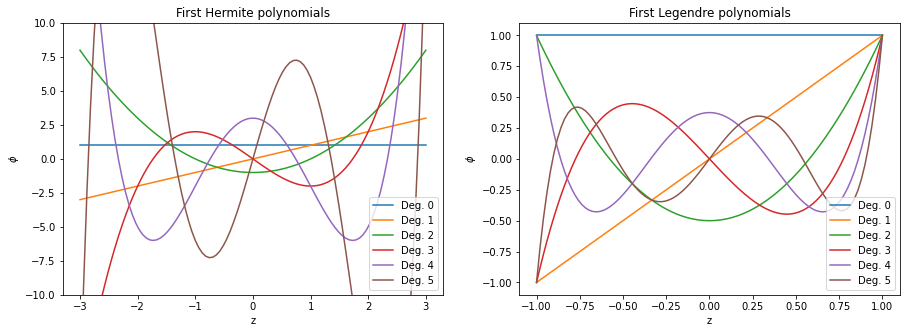

In [10]:
def plot_univariate_polynomial_helper(
    polynomial: UnivariatePC,
    ax: plt.Axes,
    z_min: float,
    z_max: float,
    y_min: float,
    y_max: float,
) -> None:
    z = np.linspace(z_min, z_max, 100)
    phi = polynomial(z)

    for d in range(polynomial.deg + 1):
        ax.plot(z, phi[:, d], label=f"Deg. {d}")

    ax.legend()
    ax.set_xlabel("z")
    ax.set_ylabel(r"$\phi$")
    ax.set_ylim(y_min, y_max)


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
plot_univariate_polynomial_helper(
    HermitePC(5), axes[0], z_min=-3.0, z_max=3.0, y_min=-10.0, y_max=10.0
)
plot_univariate_polynomial_helper(
    LegendrePC(5), axes[1], z_min=-1.0, z_max=1.0, y_min=-1.1, y_max=1.1
)
axes[0].set_title("First Hermite polynomials")
axes[1].set_title("First Legendre polynomials")

## Multivariate polynomials

A polynomial chaos expansion of a multivariate random variable is written
$$
Y(Z) \approx \sum_{\alpha\in\mathcal{I}} w_\alpha \phi_{\alpha}(Z) = \sum_{\alpha\in\mathcal{I}} w_\alpha  \phi^1_{\alpha_1}(Z_1)...\phi^d_{\alpha_d}(Z_d).
$$

The link between the multi-indices $\mathcal{I}$ and the univariate polynomials $(\phi^d_{\alpha_d})_{d,\alpha_d}$ is handled by the `MultivariatePCBasis` class. This class handles multi-indices associated to the full-tensorization of the polynomial basis, or to the total degree-based truncation scheme.

The only missing component for building a polynomial chaos expansion of a random variable are the different operations between the algebraic weights $(w_\alpha)_{\alpha\in\mathcal{I}}$ and the basis $(\phi_\alpha)_{\alpha\in\mathcal{I}}$ in order to quickly compute the mean, variance, sensitivity coefficients, ...


***WARNING: implementation details for advanced users only. The reader can skip over the MultivariatePCBasis implementation to the next section.***

In [11]:
def build_multi_index_table(
    degs: Sequence[int], total_degree: bool, max_total_degree: Optional[int] = None
) -> npt.NDArray[np.int_]:
    indices_1d = [range(deg + 1) for deg in degs]
    grids = np.meshgrid(*indices_1d, indexing="ij")
    multi_index: npt.NDArray[np.int_] = np.array([grid.ravel() for grid in grids]).T
    if total_degree:
        if max_total_degree is None:
            max_total_degree = np.max(degs)
        deg_condition = multi_index.sum(axis=1) <= max_total_degree
        multi_index = multi_index[deg_condition]
    return multi_index


class MultivariatePCBasis:
    def __init__(
        self,
        polynomials: Sequence[UnivariatePC],
        total_degree=False,
        max_total_degree=None,
    ):
        self.polynomials = polynomials
        self.degs = tuple(p.deg for p in polynomials)
        self.dim = len(self.polynomials)
        self.multi_index = build_multi_index_table(
            self.degs, total_degree, max_total_degree
        )
        self.size = len(self.multi_index)

    def _basis_product(self, values_1d: Sequence[NDArray]) -> NDArray:
        sample_size = values_1d[0].shape[0]

        phi = np.ones((sample_size, self.size))
        for n in range(sample_size):
            for k in range(self.size):
                for d in range(self.dim):
                    alpha = self.multi_index[k, d]
                    phi[n, k] *= values_1d[d][n, alpha]
        return phi

    def _fast_basis_product(self, values_1d: Sequence[NDArray]) -> NDArray:
        phi: NDArray = values_1d[0][:, self.multi_index[:, 0]]
        for d in range(1, self.dim):
            phi *= values_1d[d][:, self.multi_index[:, d]]
        return phi

    def __call__(self, z: NDArray) -> NDArray:
        z = np.atleast_2d(z)
        assert z.shape[1] == self.dim

        values_1d = [p(z[:, d]) for d, p in enumerate(self.polynomials)]
        return self._fast_basis_product(values_1d)

    def grad(self, z: NDArray) -> NDArray:
        z = np.atleast_2d(z)
        assert z.shape[1] == self.dim

        values_1d = [p(z[:, d]) for d, p in enumerate(self.polynomials)]
        grad_1d = [p.grad(z[:, d]) for d, p in enumerate(self.polynomials)]

        grad_phi = np.empty((z.shape[0], self.size, self.dim))
        for i in range(self.dim):
            v = []
            for j in range(self.dim):
                if i == j:
                    v.append(grad_1d[j])
                else:
                    v.append(values_1d[j])
            grad_phi[:, :, i] = self._fast_basis_product(v)
        return grad_phi

    def sample_z(self, sample_size: int) -> NDArray:
        z = np.empty((sample_size, self.dim))
        for d, p in enumerate(self.polynomials):
            z[:, d] = p.sample_z(sample_size)
        return z

    def sample(self, sample_size: int) -> NDArray:
        values_1d = [p.sample(sample_size) for p in self.polynomials]
        return self._fast_basis_product(values_1d)

    def square_norm(self) -> NDArray:
        sqn_1d = [np.atleast_2d(p.square_norm()) for p in self.polynomials]
        return self._fast_basis_product(sqn_1d).flatten()

    def norm(self) -> NDArray:
        return np.sqrt(self.square_norm())

## Polynomial chaos-based random vector

Finally, the implementation of a polynomial chaos-based random vector is performed below.

In [54]:
class PCRandomVector:
    def __init__(self, basis: MultivariatePCBasis, w: NDArray):
        self.basis = basis
        self.w = w if w.ndim > 1 else w[:, np.newaxis]

    def __call__(self, z: NDArray) -> NDArray:
        basis_value = self.basis(z)
        return basis_value @ self.w

    def grad(self, z: NDArray) -> NDArray:
        return np.einsum("nsd,so->nod", self.basis.grad(z), self.w)

    def sample_z(self, sample_size: int):
        return self.basis.sample_z(sample_size)

    def sample(self, sample_size: int):
        basis_value = self.basis.sample(sample_size)
        return basis_value @ self.w

    def mean(self) -> Union[float, NDArray]:
        return self.w[0]

    def variance(self) -> Union[float, NDArray]:
        basis_square_norm = self.basis.square_norm()
        return np.dot(basis_square_norm[1:], self.w[1:] ** 2)

### PCRandomVector crash course

In [55]:
# usage
deg = 3
output_dim = 4
sample_size = 10

# Build the MultivariatePCBasis object
univariate_polynomials = [HermitePC(deg), LegendrePC(deg)]
input_dim = len(univariate_polynomials)
basis = MultivariatePCBasis(univariate_polynomials, total_degree=False)

# Initialize the weights
w = stats.norm.rvs(size=(basis.size, output_dim))

# The PCRandomVector is ready
f = PCRandomVector(basis, w)

# We can now sample from f(Z)
print(f.sample(sample_size))

# Sample from the Z distribution
z = f.sample_z(sample_size)

# Evaluate the polynomial for a sample z
y = f(z)

# The evaluation of the full basis can be performed this way
phi = basis(z)

print(basis.size == (deg + 1) ** 2)
print(phi.shape == (sample_size, basis.size))

[[-0.32666096 -1.94846935 -1.60561541  2.1783357 ]
 [ 1.95817372  0.85595791  2.18664039 -4.02227201]
 [ 0.32568843  0.69129895 -0.27058852 -1.53549136]
 [-5.09921361 -2.56301391  1.67447133  1.25907988]
 [-4.39510302 -2.43682378  1.28731339  0.36937132]
 [-4.54654463 -1.22627484 -2.2794386   0.71224439]
 [-1.79754867 -0.72982537 -1.29125894 -2.13842967]
 [-2.64759207 -2.47242957 -1.80459268 -0.99024138]
 [ 2.35531391  0.3743631   1.85693214 -4.04218394]
 [ 1.04848478 -2.26519301  2.14547752 -1.74929865]]
True
True


The gradient of Y with respect to Z is available. Beware that we have the gradient is working sample-wise, i.e.
$$
y_{grad}[i] = \nabla f(z[i]).
$$

In [56]:
y_grad = f.grad(z)

print(y_grad.shape == (sample_size, output_dim, input_dim))

True


## Stress regression

The weights of the polynomial chaos expansion are computed via regression. The weights are selected using **hold-out validation**.
Per hyperparameters values (e.g. degree of the polynomials), the optimal weights are computed on **the training set**.
The best hyperparameters is selected on the **validation set**.
The best model is finally assessed on the **test set**.

Once the best hyperparameters are selected, there is no turning back

In [57]:
train_size = 4000
val_size = 500
test_size = 500

z_train = Z[:train_size]
z_val = Z[train_size : train_size + val_size]
z_test = Z[-test_size:]

y_train = Y[:train_size]
y_val = Y[train_size : train_size + val_size]
y_test = Y[-test_size:]

Let us detail how to compute the solution of the regression problem in this cell. Recall that the truncated polynomial chaos expansion is
$$
Y_{PC}(Z) = \sum_{\alpha \in \mathcal{I}} w_\alpha \phi_\alpha(Z).
$$
If the multi-index set $\mathcal{I}$ is ordered, we can similarly write
$$
Y_{PC}(Z) = \sum_{p=0}^P w_p \phi_p(Z) = \boldsymbol{\phi}(Z)w, \quad \text{with} \quad \boldsymbol{\phi}(Z) = (\phi_p(Z))_{p=1}^P \text{ and } w=(w_p)_{p=1}^P.
$$

Given a sample $(z_i, y_i)_{i=1}^N$, the minimization of the mean squared error (i.e. least squares problem) is
$$
\min_{w} \frac{1}{N} \sum_{i=1}^N \Vert y_i - \boldsymbol{\phi}(z_i)w\Vert^2.
$$
The solution to this equation is given by
$$
\left(\frac{1}{N} \sum_{i=1}^N \boldsymbol{\phi}(z_i)^T \boldsymbol{\phi}(z_i)\right)w = \frac{1}{N} \sum_{i=1}^N \boldsymbol{\phi}(z_i)^T y_i.
$$

When the number of sample is small, one can penalize the least square problem in order to improve the model. For instance, in **ridge regression**, the cost function is penalized with the square norm of the weights, i.e. we solve
$$
\min_{w} \frac{1}{N} \sum_{i=1}^N \Vert y_i - \boldsymbol{\phi}(z_i)w\Vert^2 + \frac{C}{2} \Vert w \Vert^2.
$$
Advanced linear models for regression which can be combined with polynomial chaos expansions are readily available in the `scikit-learn` library, see the [`scikit-learn` user guide](https://scikit-learn.org/stable/modules/linear_model.html#linear-model).

In [64]:
deg = 2
polynomials = [
    HermitePC(deg),
    HermitePC(deg),
    LegendrePC(deg),
    LegendrePC(deg),
    LegendrePC(deg),
]
basis = MultivariatePCBasis(polynomials=polynomials, total_degree=False)

phi_train = basis(z_train)

a = phi_train.T @ phi_train / train_size
b = phi_train.T @ y_train / train_size
w = linalg.solve(a, b, assume_a="her")

y_pc = PCRandomVector(basis, w)

y_val_pred = y_pc(z_val)
error_val = linalg.norm(y_val - y_val_pred) / linalg.norm(y_val)
print("Validation error:", error_val)

Validation error: 0.009140697478577153


The matrix `a` is an approximation of the Gram matrix for the $L^2$ inner product between the polynomial basis, meaning that
$$
\mathbb{E}(\phi_\alpha\phi_\beta) \approx a_{\alpha\beta} = \frac{1}{N}\sum_{i=1}^N \phi_\alpha(z_i) \phi_\beta(z_i).
$$
Given that the polynomial basis is orthogonal, we expect that the matrix `a` is almost a diagonal matrix, such that the problem is well-conditioned with a large enough sample $(z_i)_{i=1}^N$.

In [69]:
print(a[:4, :4])

[[ 1.         -0.00619867  0.00517936  0.00218823]
 [-0.00619867  0.33678624 -0.00195295  0.0049174 ]
 [ 0.00517936 -0.00195295  0.20310506  0.00103698]
 [ 0.00218823  0.0049174   0.00103698  0.3262046 ]]


**The best model is selected. Y_PC is now defined and fixed in the next cell.**

In [70]:
Y_PC = copy.deepcopy(y_pc)
del y_pc

y_test_pred = Y_PC(z_test)
error_test = linalg.norm(y_test - y_test_pred) / linalg.norm(y_test)
print("Test error:", error_test)

Test error: 0.0070843624080235024


Let us compare the prediction from the truncated polynomial chaos expansion and the data on a curve.

Text(0, 0.5, '$\\sigma_{xy}$')

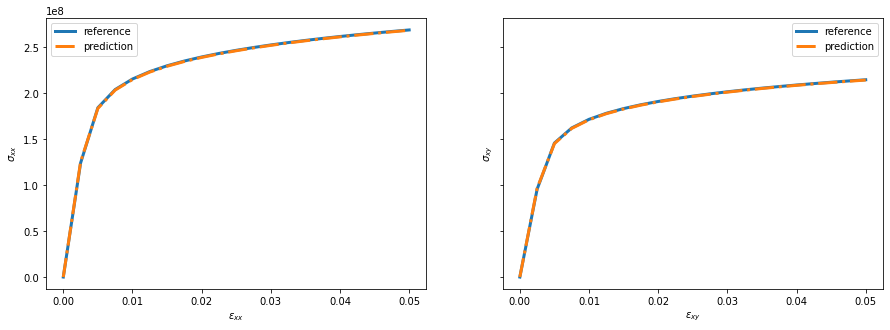

In [72]:
sample_id = stats.randint.rvs(low=0, high=len(Y))

strain, tensile_stress, shear_stress = extract_strain_stresses(Y[sample_id])

y_pred = Y_PC(Z[sample_id])[0]
_, tensile_stress_pred, shear_stress_pred = extract_strain_stresses(y_pred)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 5))
axes[0].plot(strain, tensile_stress, label="reference", linewidth=3)
axes[0].plot(
    strain, tensile_stress_pred, label="prediction", linewidth=3, linestyle="-."
)
axes[1].plot(strain, shear_stress, label="reference", linewidth=3)
axes[1].plot(strain, shear_stress_pred, label="prediction", linewidth=3, linestyle="-.")

axes[0].legend()
axes[0].set_xlabel(r"$\varepsilon_{xx}$")
axes[0].set_ylabel(r"$\sigma_{xx}$")
axes[1].legend()
axes[1].set_xlabel(r"$\varepsilon_{xy}$")
axes[1].set_ylabel(r"$\sigma_{xy}$")

We can now quickly evaluate some quantities of interest without Monte-Carlo sampling. We recall that the truncated polynomial chaos expansion has the form
$$
Y_{PC}(Z) = \sum_{\alpha\in\mathcal{I}} w_\alpha \phi_{\alpha}(Z).
$$
For instance, we have
$$
\mathbb{E}\left(Y_{PC}(Z)\right) = w_{\mathbf{0}},
$$
or
$$
\mathbb{V}\left(Y_{PC}(Z)\right) = \sum_{\alpha\in\mathcal{I} \setminus \{0\}} w_\alpha^2 \Vert\phi_\alpha^2\Vert, \qquad \text{with} \qquad \Vert\phi_\alpha^2\Vert = \mathbb{E}(\phi_\alpha(Z)^2).
$$


Text(0, 0.5, '$\\sigma_{xy}$')

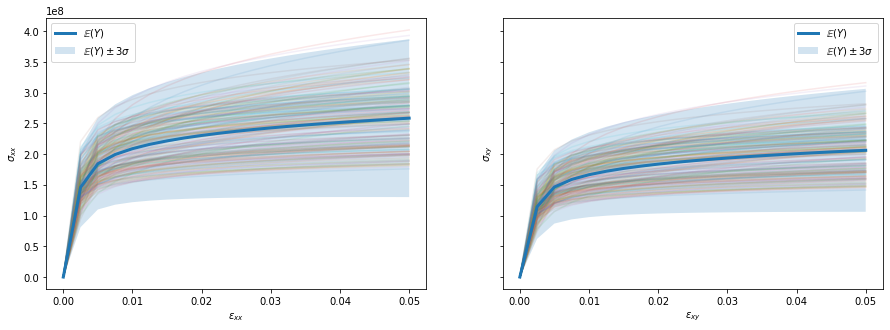

In [73]:
y_mean = Y_PC.mean()
y_var = Y_PC.variance()
y_std = np.sqrt(y_var)

strain, expected_tensile_stress, expected_shear_stress = extract_strain_stresses(y_mean)
_, std_tensile_stress_pred, std_shear_stress_pred = extract_strain_stresses(y_std)
std_tensile_stress_pred[0] = 0.0
std_shear_stress_pred[0] = 0.0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(15, 5))

num_curves = 200
for _ in range(num_curves):
    sample_id = np.random.randint(low=0, high=len(Y))
    y = Y[sample_id]
    strain, tensile_stress, shear_stress = extract_strain_stresses(y)

    axes[0].plot(strain, tensile_stress, alpha=0.1)
    axes[1].plot(strain, shear_stress, alpha=0.1)


axes[0].plot(strain, expected_tensile_stress, label="$\mathbb{E}(Y)$", linewidth=3)
axes[0].fill_between(
    strain,
    expected_tensile_stress - 3 * std_tensile_stress_pred,
    expected_tensile_stress + 3 * std_tensile_stress_pred,
    label="$\mathbb{E}(Y) \pm 3 \sigma$",
    linewidth=3,
    linestyle="-.",
    alpha=0.2,
)
axes[0].legend()
axes[0].set_xlabel(r"$\varepsilon_{xx}$")
axes[0].set_ylabel(r"$\sigma_{xx}$")

axes[1].plot(strain, expected_shear_stress, label="$\mathbb{E}(Y)$", linewidth=3)
axes[1].fill_between(
    strain,
    expected_shear_stress - 3 * std_shear_stress_pred,
    expected_shear_stress + 3 * std_shear_stress_pred,
    label="$\mathbb{E}(Y) \pm 3 \sigma$",
    linewidth=3,
    linestyle="-.",
    alpha=0.2,
)
axes[1].legend()
axes[1].set_xlabel(r"$\varepsilon_{xy}$")
axes[1].set_ylabel(r"$\sigma_{xy}$")

# Global sensitivity analysis

The goal of the section is to quantify the proportions of the model output uncertainties induced by the uncertainties of each input parameter. In particular, we will exploit the properties of polynomial chaos to efficiently evaluate sensitivity indices called Sobol indices.

The Sobol decomposition of a random variable with finite variance ($L^2$ functions) may be decomposed under the form
$$
Y(Z) = Y_0 + \sum_{i=1}^d Y_i(Z_i) + \sum_{i<j}^d Y_{ij}(Z_i, Z_j) + ... + Y_{1...d}(Z_1, ..., Z_d).
$$
The Sobol decomposition is unique when orthogonality is required:
$$
\mathbb{E}(Y_\alpha Y_\beta) = 0 \qquad \text{if} \qquad \alpha \ne \beta.
$$
In this case, the variance can be decomposed under the form
$$
\mathbb{V}(Y) = \sum_{i=1}^d \mathbb{V}(Y_i) + ... + \mathbb{V}(Y_{1,...,d}),
$$
or
$$
1 = \sum_{i=1}^d \frac{\mathbb{V}(Y_i)}{\mathbb{V}(Y)} + ... + \frac{\mathbb{V}(Y_{1,...,d})}{\mathbb{V}(Y)}.
$$

The first order Sobol index  $S_i = \frac{\mathbb{V}(Y_i)}{\mathbb{V}(Y)}$ corresponds to the proportion of the total variance induced by the single input variable $Z_i$.

The total order Sobol index $T_i = \sum_{i\in\alpha} S_\alpha$ corresponds to the proportion of the total variance induced by the variable $Z_i$ including all the interactions.

## Monte-Carlo estimation

A popular sampling approach in order to estimate the Sobol indices is due to Saltelli implemented below.

Without going into the details, two samples of $Z$ (`sample_a` and `sample_b`) are required in order to use the function `compute_sobol_indices_mc`.
Note that the function is generic enough to be used for any callable model $f$, being polynomial-based or not.

In [74]:
def compute_sobol_indices_mc(
    sample_a: NDArray,
    sample_b: NDArray,
    f: Callable[[NDArray], NDArray],
    var_y: NDArray,
) -> Tuple[NDArray, NDArray]:
    sample_a = np.atleast_2d(sample_a)
    sample_b = np.atleast_2d(sample_b)
    var_y = np.atleast_1d(var_y)
    assert sample_a.shape == sample_b.shape

    z_dim = sample_a.shape[1]
    y_dim = len(var_y)
    s = np.empty((y_dim, z_dim))
    t = np.empty((y_dim, z_dim))

    f_a = f(sample_a)
    f_b = f(sample_b)
    f_ai = []

    for i in range(z_dim):
        ai = sample_a.copy()
        ai[:, i] = sample_b[:, i]
        f_ai = f(ai)

        v_i = np.mean(f_b * (f_ai - f_a), axis=0)
        e_i = 0.5 * np.mean((f_a - f_ai) ** 2, axis=0)
        s[:, i] = v_i / var_y
        t[:, i] = e_i / var_y
    return s, t

## PC-based estimation

Recall the Sobol decomposition of a random variable
$$
Y(Z) = Y_0 + \sum_{i=1}^d Y_i(Z_i) + \sum_{i<j}^d Y_{ij}(Z_i, Z_j) + ... + Y_{1...d}(Z_1, ..., Z_d).
$$
When a truncated polynomial chaos expansion is used to approximate $Z$, the Sobol decomposition is readily available.
Indeed, we have
$$
Y_{PC}(Z) = \sum_{\alpha\in\mathcal{I}} w_\alpha  \phi^1_{\alpha_1}(Z_1)...\phi^d_{\alpha_d}(Z_d),
$$
and therefore
$$
Y_i(Z_i) = \sum_{\alpha = (0,...,0,j,0,...,0)} w_\alpha  \phi^i_{\alpha_i}(Z_i).
$$
Moreover, since the polynomial chaos basis is orthogonal, the decomposition of the variance holds and the Sobol indices are easily computed.

In [75]:
def compute_sobol_indices_pc(rv: PCRandomVector) -> Tuple[NDArray, NDArray]:
    multi_index = rv.basis.multi_index
    basis_square_norm = rv.basis.square_norm()
    dim = rv.basis.dim

    s = np.zeros((rv.w.shape[1], dim))
    t = np.zeros_like(s)

    for i, alpha in enumerate(multi_index):
        # First order Sobol indices
        # We need to find indices such that only one component is not null
        # Either [n, 0, ..., 0], [0, n, 0, ..., 0],
        if sum(alpha == 0) == dim - 1:
            d = np.argmax(alpha)
            s[:, d] += rv.w[i] ** 2 * basis_square_norm[i]

        # Total order Sobol indices
        if any(alpha > 0):
            for d in range(dim):
                if alpha[d] > 0:
                    t[:, d] += rv.w[i] ** 2 * basis_square_norm[i]

    variance = np.atleast_1d(rv.variance())
    variance = variance[:, np.newaxis]
    s /= variance
    t /= variance
    return s, t

In [76]:
sample_size = 1000
s_mc, t_mc = compute_sobol_indices_mc(
    Y_PC.basis.sample_z(sample_size),
    Y_PC.basis.sample_z(sample_size),
    Y_PC,
    Y_PC.variance(),
)
s_pc, t_pc = compute_sobol_indices_pc(Y_PC)
print(s_mc[:, 4])
print(s_pc[:, 4])

[        nan  0.21375575  0.05674966 -0.01303886 -0.03177533 -0.03276907
 -0.02657977 -0.01732281 -0.00681903  0.0040627   0.01489257  0.0254518
  0.03563905  0.0454086   0.05474867  0.06366605  0.07217473  0.08029491
  0.08804846  0.09545611  0.10254089         nan  0.22375285  0.088612
  0.0049884  -0.02423911 -0.03276362 -0.03209943 -0.02700948 -0.01971725
 -0.01136199 -0.00255077  0.00637542  0.01522526  0.02389157  0.03231264
  0.04045997  0.04831939  0.05589201  0.06317994  0.07019216  0.07694084]
[           nan 8.82126142e-02 2.37836758e-02 2.91924965e-06
 1.03571554e-02 3.01280507e-02 5.20209783e-02 7.36242901e-02
 9.41191830e-02 1.13270042e-01 1.31066455e-01 1.47584610e-01
 1.62929529e-01 1.77211222e-01 1.90533715e-01 2.02992786e-01
 2.14673838e-01 2.25651633e-01 2.35993585e-01 2.45758154e-01
 2.54997534e-01            nan 9.29034762e-02 4.17336233e-02
 2.75635806e-03 2.41193913e-03 1.49755725e-02 3.18665970e-02
 4.98944867e-02 6.77731684e-02 8.49747775e-02 1.01298572e-01
 1.

/tmp/ipykernel_1498/4158731632.py:28: RuntimeWarning: invalid value encountered in true_divide
  s[:, i] = v_i / var_y
/tmp/ipykernel_1498/4158731632.py:29: RuntimeWarning: invalid value encountered in true_divide
  t[:, i] = e_i / var_y
/tmp/ipykernel_1498/1337335813.py:25: RuntimeWarning: invalid value encountered in true_divide
  s /= variance
/tmp/ipykernel_1498/1337335813.py:26: RuntimeWarning: invalid value encountered in true_divide
  t /= variance


The first-order and total-order Sobol indices are finally linked to the simulated tensile and shear tests.

Text(0.5, 0, '$\\varepsilon_{xy}$')

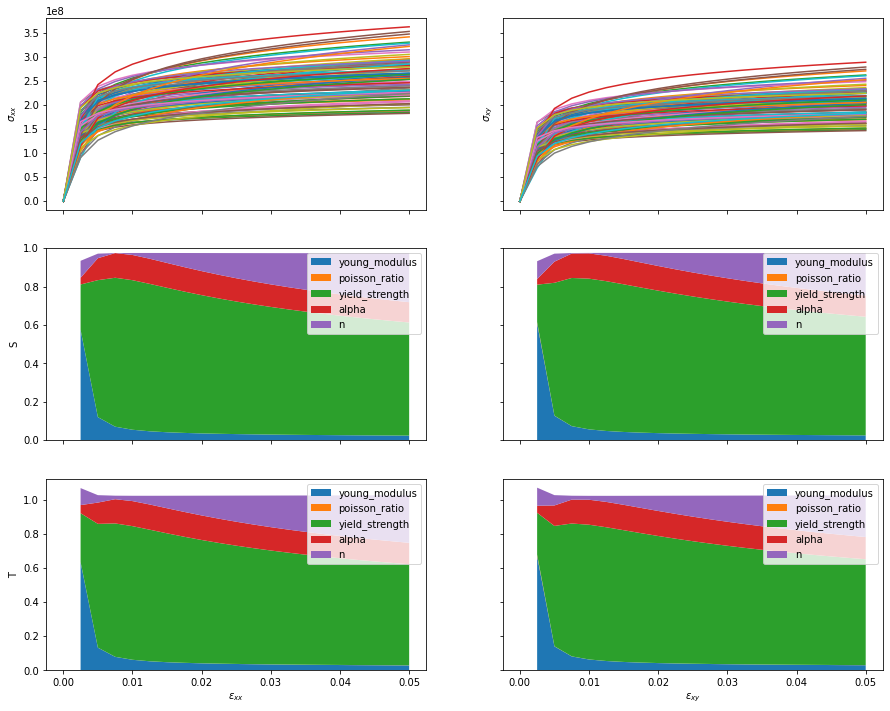

In [77]:
num_curves = 100

fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, sharey="row", figsize=(15, 12))
for i in range(num_curves):
    sample_id = stats.randint(low=0, high=len(Y)).rvs()
    y = Y[sample_id]
    strain, tensile_stress, shear_stress = extract_strain_stresses(y)
    axes[0, 0].plot(strain, tensile_stress)
    axes[0, 1].plot(strain, shear_stress)
axes[0, 0].set_ylabel(r"$\sigma_{xx}$")
axes[0, 1].set_ylabel(r"$\sigma_{xy}$")

num_strain_steps = len(strain)
axes[1, 0].stackplot(strain, s_pc[:num_strain_steps].T, labels=PARAMETER_NAMES)
axes[1, 1].stackplot(strain, s_pc[num_strain_steps:].T, labels=PARAMETER_NAMES)
axes[1, 0].set_ylim(0, 1)
axes[1, 1].set_ylim(0, 1)
axes[1, 0].legend()
axes[1, 1].legend()
axes[1, 0].set_ylabel("S")

axes[2, 0].stackplot(strain, t_pc[:num_strain_steps].T, labels=PARAMETER_NAMES)
axes[2, 1].stackplot(strain, t_pc[num_strain_steps:].T, labels=PARAMETER_NAMES)
axes[2, 0].legend()
axes[2, 1].legend()
axes[2, 0].set_ylabel("T")
axes[2, 0].set_xlabel(r"$\varepsilon_{xx}$")
axes[2, 1].set_xlabel(r"$\varepsilon_{xy}$")

# Bayesian inference

From now on, we assume that some experimental data $y_e$ are available in the variable `Y_EXP`.
We suppose that $y_e$ is the realization of a random variable distributed according to the following model:
$$
Y_e = Y(Z) + \varepsilon,
$$
where $\varepsilon \sim \mathcal{N}(0,\sigma^2 \mathbb{I})$ is independent from $Z$.

Text(0, 0.5, '$\\sigma_{xy}$')

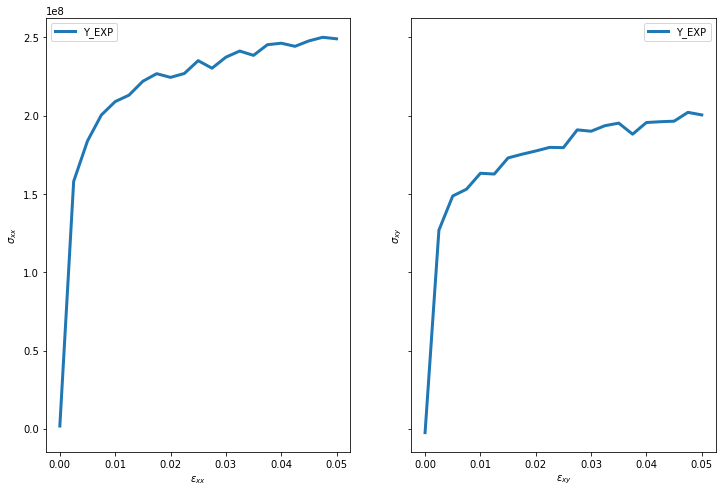

In [78]:
NOISE_SIGMA = 3e6
Y_EXP = Y_TRUE + NOISE_SIGMA * stats.norm.rvs(size=Y_TRUE.shape)

strain, tensile_stress, shear_stress = extract_strain_stresses(Y_EXP)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 8))
axes[0].plot(strain, tensile_stress, label="Y_EXP", linewidth=3)
axes[1].plot(strain, shear_stress, label="Y_EXP", linewidth=3)


axes[0].legend()
axes[0].set_xlabel(r"$\varepsilon_{xx}$")
axes[0].set_ylabel(r"$\sigma_{xx}$")
axes[1].legend()
axes[1].set_xlabel(r"$\varepsilon_{xy}$")
axes[1].set_ylabel(r"$\sigma_{xy}$")

The goal of this section is to use Bayes theorem in order to improve our knowledge over the distribution of the rescaled material parameters $Z$ after having observed the data $Y_e= y_e$.
The Bayes theorem states that
$$
p(Z\mid Y_e=y_e) = \frac{p(Y_e=y_e \mid Z)p(Z)}{p(Y_e=y_e)},
$$
where

* $p(Z)$ is the **prior distribution**, i.e. the distribution of the parameter before having observed any data,
* $p(Y_e=y_e\mid Z)$ is the **likelihood**, describing the probability of the data $Y=y$ knowing the parameter $Z$,
* $p(X\mid Y_e=y_e)$ is the **posterior distribution**, i.e. the updated distribution of $X$ after seeing the data $y_e$,
* $p(Y_e=y_e)$ is the **evidence**, the probability of the data that does not involve the parameter $Z$ (scaling factor).

The evidence being independent from $Z$, it is common to consider that the **posterior** is proportional to the **likelihood** times the **prior**:
$$
p(Z\mid Y_e=y_e) \propto p(Y_e=y_e \mid Z)p(Z).
$$

The prior distribution $p(Z)$ is the distribution of $Z$ that was given at the beginning of the course.

The likelihood is deduced from the statistical model $Y_e = Y(Z) + \varepsilon$. Indeed, knowing ("fixing") $Z$ implies
$$
p(Y_e \mid Z) \sim \mathcal{N}(Y(Z), \sigma^2 \mathbb{I}).
$$

Therefore we conclude that
$$
\log p(Z \mid Y_e=y_e) = -\frac{1}{2} \frac{\Vert y_e - Y(Z)\Vert^2 }{\sigma^2} + \log p(Z) + K, \qquad K\in\mathbb{R}.
$$

## Maximum A Posteriori estimate

Before estimating the full posterior distribution, we can estimate a value of the parameter $Z$ that has maximize the density of the posterior distribution. A **Maximum A Posteriori** (MAP) estimate $z_{MAP}$ is the mode of the posterior distribution, maximizing the posterior probability density function, i.e. it satisfies the the relation
$$
p(z_{MAP}\mid Y_e=y_e) = \max_z p(z\mid Y_e=y_e).
$$
In this section, we compute $z_{MAP}$ using `scipy.minimize` using an implementation of the likelihood, prior density function and their derivatives.

In [79]:
def log_prior(z: NDArray) -> NDArray:
    z = np.atleast_2d(z)
    norm = stats.norm()
    unif = stats.uniform(loc=-1.0, scale=2.0)
    return (
        norm.logpdf(z[:, 0])
        + norm.logpdf(z[:, 1])
        + unif.logpdf(z[:, 2])
        + unif.logpdf(z[:, 3])
        + unif.logpdf(z[:, 4])
    )


def grad_log_prior(z: NDArray) -> NDArray:
    z = np.atleast_2d(z)
    g = np.zeros_like(z)
    g[:, 0] = -z[:, 0]
    g[:, 1] = -z[:, 1]
    return g


def log_likelihood_slow(rv: PCRandomVector, z: NDArray, y: NDArray) -> NDArray:
    z = np.atleast_2d(z)
    size = len(z)
    y_pred = rv(z)
    loglkh = np.empty(size)
    for i in range(size):
        loglkh[i] = -0.5 * np.dot(y - y_pred[i], y - y_pred[i]) / NOISE_SIGMA**2
    return loglkh


def log_likelihood(rv: PCRandomVector, z: NDArray, y: NDArray) -> NDArray:
    z = np.atleast_2d(z)
    e = y[np.newaxis, :] - rv(z)
    e_square = np.einsum("ij,ij->i", e, e)
    return -0.5 * e_square / NOISE_SIGMA**2


def grad_log_likelihood_slow(rv: PCRandomVector, z: NDArray, y: NDArray) -> NDArray:
    z = np.atleast_2d(z)
    size = len(z)
    y_pred = rv(z)
    y_pred_grad = rv.grad(z)
    g = np.zeros_like(z)
    for i in range(size):
        g[i] = np.dot((y - y_pred[i]), y_pred_grad[i]) / NOISE_SIGMA**2
    return g


def grad_log_likelihood(rv: PCRandomVector, z: NDArray, y: NDArray) -> NDArray:
    z = np.atleast_2d(z)
    e = y[np.newaxis, :] - rv(z)
    y_pred_grad = rv.grad(z)
    return np.einsum("ij,ijk->ik", e, y_pred_grad) / NOISE_SIGMA**2


def log_joint_proba(rv: PCRandomVector, z: NDArray, y: NDArray) -> NDArray:
    return log_likelihood(rv, z, y) + log_prior(z)


def grad_log_joint_proba(rv: PCRandomVector, z: NDArray, y: NDArray) -> NDArray:
    return grad_log_likelihood(rv, z, y) + grad_log_prior(z)

In [80]:
def compute_map_estimate(
    rv: PCRandomVector, z0: NDArray, y: NDArray
) -> Dict[str, float]:
    result = optimize.minimize(
        lambda z: -log_joint_proba(rv, z, y).squeeze(axis=0),
        z0,
        jac=lambda z: -grad_log_joint_proba(rv, z, y).squeeze(axis=0),
        bounds=((None, None), (None, None), (-1, 1), (-1, 1), (-1, 1)),
        method="l-bfgs-b",
    )
    result_x = z2x(result.x).ravel()
    data = {p: result_x[i] for i, p in enumerate(PARAMETER_NAMES)}
    data["log_joint_proba"] = -result.fun
    return data

The computation of the MAP estimate is performed using a gradient-based algorithm and several initial guesses.

In [81]:
num_optimization = 20

map_data = []
for _ in range(num_optimization):
    print(".", end="")
    z0 = Y_PC.sample_z(sample_size=1).squeeze(axis=0)
    data = compute_map_estimate(Y_PC, z0, Y_EXP)
    map_data.append(data)

map_data.sort(key=lambda _: _["log_joint_proba"], reverse=True)

....................

In [82]:
print(map_data[0])
print(map_data[-1])

{'young_modulus': 85462362189.96947, 'poisson_ratio': 0.30003905762854677, 'yield_strength': 166698705.73730698, 'alpha': 0.5, 'n': 9.186481543680593, 'log_joint_proba': -22.766732741966308}
{'young_modulus': 214047105833.4096, 'poisson_ratio': 0.33152323691990526, 'yield_strength': 183274756.9205407, 'alpha': 1.8947211321273827, 'n': 15.0, 'log_joint_proba': -41.42566997900148}


Below is the comparison between the data $y_e$ and the prediction at $z_{MAP}$, i.e. $Y_{PC}(z_{MAP})$.

Text(0, 0.5, '$\\sigma_{xy}$')

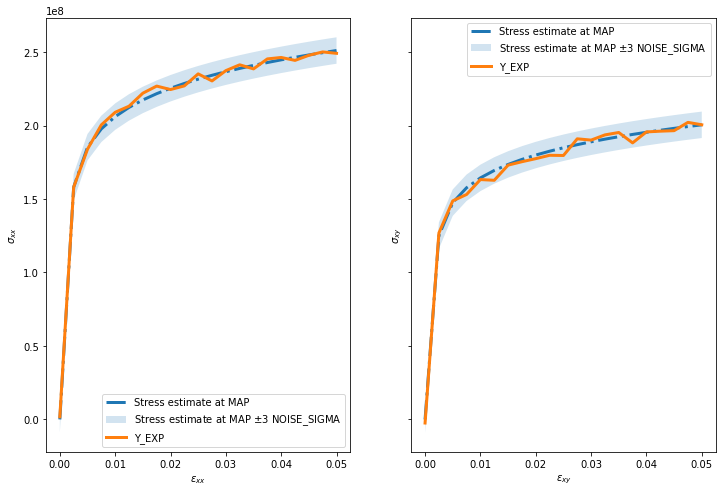

In [83]:
x_map = np.array([map_data[0][p] for p in PARAMETER_NAMES])
z_map = x2z(x_map)
y_map_pred = Y_PC(z_map).squeeze(axis=0)

strain, tensile_stress, shear_stress = extract_strain_stresses(Y_EXP)
_, tensile_stress_pred, shear_stress_pred = extract_strain_stresses(y_map_pred)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 8))
axes[0].plot(
    strain,
    tensile_stress_pred,
    label="Stress estimate at MAP",
    linewidth=3,
    linestyle="-.",
)
axes[0].fill_between(
    strain,
    tensile_stress_pred - 3 * NOISE_SIGMA,
    tensile_stress_pred + 3 * NOISE_SIGMA,
    alpha=0.2,
    label="Stress estimate at MAP $\pm 3$ NOISE_SIGMA",
)
axes[0].plot(strain, tensile_stress, label="Y_EXP", linewidth=3)

axes[1].plot(
    strain,
    shear_stress_pred,
    label="Stress estimate at MAP",
    linewidth=3,
    linestyle="-.",
)
axes[1].fill_between(
    strain,
    shear_stress_pred - 3 * NOISE_SIGMA,
    shear_stress_pred + 3 * NOISE_SIGMA,
    alpha=0.2,
    label="Stress estimate at MAP $\pm 3$ NOISE_SIGMA",
)
axes[1].plot(strain, shear_stress, label="Y_EXP", linewidth=3)


axes[0].legend()
axes[0].set_xlabel(r"$\varepsilon_{xx}$")
axes[0].set_ylabel(r"$\sigma_{xx}$")
axes[1].legend()
axes[1].set_xlabel(r"$\varepsilon_{xy}$")
axes[1].set_ylabel(r"$\sigma_{xy}$")

## Black-box Variational Inference

Finally, we will try to approximate the posterior distribution $p(Z\mid Y_e=y_e)$ by another variational distribution $q(Z)$.
The variation distribution $q(Z)$ is computed by minimizing the **Kullback-Leibler divergence** between the two distributions.
The Kullback-Leibler divergence is a statistical distance measuring the similarity between two distributions. It is defined by
$$
\mathrm{KL}(q(Z)\Vert p(Z\mid Y_e))= \mathbb{E}_{q}\left(\frac{q(Z)}{p(Z\mid Y_e)}\right).
$$
The direct minimization of the Kullback-Leibler divergence is tedious. The standard approach to circumvent this issue is to use the relationship
$$
\mathrm{KL}(q(Z)\Vert p(Z\mid Y_e))=\log p(Y_e) - \mathcal{L}(q),
$$
where $\mathcal{L}(q)$ is the Evidence Lower BOund (ELBO) defined by
$$
\mathcal{L}(q) = \mathbb{E}_{q}\left(\log \frac{p(Y_e\mid Z)p(Z)}{q(Z)}\right) = \mathbb{E}_{q}\left(\log p(Y_e\mid Z) + \log p(Z) - \log q(Z)\right).
$$

Since $p(Y_e)$ does not depend on the variational distribution $q$, minimizing the Kullback-Leibler divergence is equivalent to maximizing the Evidence Lower Bound (ELBO) $\mathcal{L}(q)$.

We therefore look for the optimizal variational distribution $q$ by solving the optimization problem
$$
\max_{q\in\mathcal{Q}} \mathcal{L}(q).
$$
For this course, the set of variational distributions $\mathcal{Q}$ satisfies the **mean field** approximation
$$
q(Z) = \prod_{i} q(Z_i),
$$
where $q(Z_1)$ and $q(Z_2)$ are assumed to be normal, while $q(Z_3)$, $q(Z_4)$, and $q(Z_5)$ are assumed to follow a truncated normal distribution.

## Utilities to define the Mean-Field Variational Distribution and the ELBO

In [84]:
def norm_score(z, loc, scale):
    g = np.empty((len(z), 2))
    g[:, 0] = (z - loc) / (scale**2)
    g[:, 1] = (z - loc) ** 2 / (scale**3) - 1 / scale
    return g


def truncnorm_rvs(size, loc, scale, low, high):
    a, b = (low - loc) / scale, (high - loc) / scale
    return stats.truncnorm.rvs(size=size, a=a, b=b, loc=loc, scale=scale)


def truncnorm_logpdf(z, loc, scale, low, high):
    a, b = (low - loc) / scale, (high - loc) / scale
    return stats.truncnorm.logpdf(z, a=a, b=b, loc=loc, scale=scale)


def truncnorm_score(z, loc, scale, low, high):
    g = norm_score(z, loc, scale)
    pdf = stats.norm.pdf
    cdf = stats.norm.cdf
    a = (low - loc) / scale
    b = (high - loc) / scale
    g[:, 0] += (pdf(b) - pdf(a)) / (scale * (cdf(b) - cdf(a)))
    g[:, 1] += (b * pdf(b) - a * pdf(a)) / (scale * (cdf(b) - cdf(a)))
    return g

In [85]:
class MFVariationalDistribution:
    def __init__(self, means, logstds):
        self.means = means
        self.logstds = logstds
        self.low = -1
        self.high = 1
        self.dim = 5

    def marginal_logpdf(self, dim: int, z: NDArray) -> NDArray:
        stds = np.exp(self.logstds)
        if dim < 2:
            return stats.norm.logpdf(z, loc=self.means[dim], scale=stds[dim])
        else:
            return truncnorm_logpdf(
                z, loc=self.means[dim], scale=stds[dim], low=self.low, high=self.high
            )

    def marginal_pdf(self, dim: int, z: NDArray) -> NDArray:
        return np.exp(self.marginal_logpdf(dim, z))

    def marginal_sample(self, dim: int, size: int) -> NDArray:
        stds = np.exp(self.logstds)
        if dim < 2:
            return stats.norm.rvs(size=size, loc=self.means[dim], scale=stds[dim])
        else:
            return truncnorm_rvs(
                size=size,
                loc=self.means[dim],
                scale=stds[dim],
                low=self.low,
                high=self.high,
            )

    def sample(self, size: int = 1) -> NDArray:
        z = np.empty((size, self.dim))
        for d in range(self.dim):
            z[:, d] = self.marginal_sample(d, size)
        return z

    def logpdf(self, z: NDArray) -> NDArray:
        result = np.zeros(len(z))
        for d in range(self.dim):
            result += self.marginal_logpdf(d, z[:, d])
        return result

    def score(self, z: NDArray) -> NDArray:
        stds = np.exp(self.logstds)

        g = np.empty((len(z), 2 * self.dim))
        for d in range(self.dim):
            if d < 2:
                gd = norm_score(z[:, d], loc=self.means[d], scale=stds[d])
            else:
                gd = truncnorm_score(
                    z[:, d],
                    loc=self.means[d],
                    scale=stds[d],
                    low=self.low,
                    high=self.high,
                )

            gd[:, 1] *= stds[d]

            g[:, d] = gd[:, 0]
            g[:, d + self.dim] = gd[:, 1]
        return g

We denote by $\theta$ the parameter defining the set of variational distribution $\mathcal{Q} = \{q_\theta\}_{\theta}$, like the mean and standard deviation of the normal distributions.

The ELBO is computed using a Monte-Carlo approximation and a sample $(z_i)_{i=1}^N$ distributed according to $q_\theta$
$$
\mathcal{L}(q_\theta) \approx \frac{1}{N}\sum_{i=1}^N \log p(y_e\mid z_i) + \log p(z_i) - \log q(z_i).
$$
The Monte-Carlo approximation of the gradient of the ELBO is then
$$
\frac{\partial \mathcal{L}(q_\theta)}{\partial \theta} \approx \frac{1}{N} \sum_{i=1}^N \frac{\partial q}{\partial \theta}(z_i;\theta)\left(
  \log p(y_e\mid z_i) + \log p(z_i) - \log q(z_i)
\right).
$$
The variational inference problem can now be solved with a stochastic optimization method like the stochastic gradient ascent :

* Initialize $\theta$, $\rho >0$,
* While $\theta$ has not converged:
  * Sample $(z_i)_{i=1}^N$ according to $q_\theta$,
  * Compute the Monte-Carlo approximation $\Delta \theta$ of $\frac{\partial \mathcal{L}(q_\theta)}{\partial \theta}$,
  * $\theta \leftarrow \theta + \rho \Delta \theta$,
* Return $q_\theta$

Two solvers are proposed to maximize the ELBO function: the stochastic gradient ascent with momentum solver (`bbvi_sga`) and the ADAM solver (`bbvi_adam`).

In [86]:
def compute_elbo_approximation(
    q: MFVariationalDistribution,
    log_prob: Callable[[NDArray, NDArray], NDArray],
    y: NDArray,
    batch_size: int,
):
    z = q.sample(batch_size)
    q_logpdf = q.logpdf(z)
    p_logpdf = log_prob(z, y)
    elbo = p_logpdf.mean() - q_logpdf.mean()
    grad_elbo = (q.score(z) * (p_logpdf[:, np.newaxis] - q_logpdf[:, np.newaxis])).mean(
        axis=0
    )
    return elbo, grad_elbo


def bbvi_sga(
    log_prob: Callable[[NDArray, NDArray], NDArray],
    y: NDArray,
    theta0: NDArray,
    batch_size: int = 1000,
    max_iter: int = 300,
    tolerance: float = 1e-3,
    lr: float = 5e-4,
    momentum: float = 0.0,
) -> MFVariationalDistribution:
    theta = theta0
    dtheta = np.zeros_like(theta)

    for t in range(max_iter):
        q = MFVariationalDistribution(theta[:5], theta[5:])
        elbo, grad_elbo = compute_elbo_approximation(q, log_prob, y, batch_size)

        dtheta = lr * grad_elbo + momentum * dtheta
        theta = theta + dtheta

        dnorm = linalg.norm(dtheta) / linalg.norm(theta)
        if dnorm < tolerance:
            print("dnorm={} is smaller than the tolerance.".format(dnorm))
            break
        if t % 50 == 0:
            print("iter={}, elbo={}, dnorm={}".format(t, elbo, dnorm))
    print("final elbo={}".format(elbo))
    return q


def bbvi_adam(
    log_prob: Callable[[NDArray, NDArray], NDArray],
    y: NDArray,
    theta0: NDArray,
    batch_size: int = 200,
    max_iter: int = 300,
    tolerance: float = 1e-3,
    lr: float = 1e-3,
    beta1: float = 0.9,
    beta2: float = 0.99,
    eps: float = 1e-8,
) -> MFVariationalDistribution:
    theta = theta0
    dtheta = np.zeros_like(theta)
    m = np.zeros_like(theta)
    v = np.zeros_like(theta)
    for t in range(max_iter):
        q = MFVariationalDistribution(theta[:5], theta[5:])
        elbo, g = compute_elbo_approximation(q, log_prob, y, batch_size)

        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * g * g
        mh = m / (1 - beta1 ** (1 + t))
        vh = v / (1 - beta2 ** (1 + t))
        dtheta = lr * mh / (np.sqrt(vh) + eps)
        theta = theta + dtheta

        dnorm = linalg.norm(dtheta) / linalg.norm(theta)
        if dnorm < tolerance:
            print("dnorm={} is smaller than the tolerance.".format(dnorm))
            break
        if t % 50 == 0:
            print("iter={}, elbo={}, dnorm={}".format(t, elbo, dnorm))
    print("final elbo={}".format(elbo))
    return q

In [87]:
theta0 = np.zeros(10)

# q = bbvi_sga(
#     lambda z, y: log_joint_proba(Y_PC, z, y),
#     Y_EXP,
#     theta0,
#     batch_size=100,
#     max_iter=2000,
#     tolerance=1e-8,
#     lr=1e-5,
#     momentum=0.9,
# )

q = bbvi_adam(
    lambda z, y: log_joint_proba(Y_PC, z, y),
    Y_EXP,
    theta0,
    batch_size=100,
    max_iter=2000,
    tolerance=1e-8,
    lr=1e-2,
)

iter=0, elbo=-2050.5195511133193, dnorm=1.0
iter=50, elbo=-1373.6457425049996, dnorm=0.02314611611289765
iter=100, elbo=-600.3021619456109, dnorm=0.010305489788257249
iter=150, elbo=-376.7223729652267, dnorm=0.0038544920761733946
iter=200, elbo=-210.83986648453165, dnorm=0.002398187253114533
iter=250, elbo=-152.55688698294202, dnorm=0.001779770979267842
iter=300, elbo=-130.84705874727155, dnorm=0.0014801081794753445
iter=350, elbo=-116.38453438854931, dnorm=0.0013873809151407812
iter=400, elbo=-106.52417041231519, dnorm=0.0013487852555491315
iter=450, elbo=-80.736110294347, dnorm=0.0017868552078394188
iter=500, elbo=-79.56735203837012, dnorm=0.0011860913959113766
iter=550, elbo=-69.79333918787582, dnorm=0.0018542184914232987
iter=600, elbo=-64.48381546856066, dnorm=0.001856668501014857
iter=650, elbo=-52.990380499770666, dnorm=0.0017548373014671062
iter=700, elbo=-49.35785737260958, dnorm=0.0010224590901889985
iter=750, elbo=-41.50687020164255, dnorm=0.0016820070035260964
iter=800, elb

Now, we can compare the density functions of the prior distribution $p(Z)$ and the approximate posterior distribution $q(Z)$, or similarly $p(X)$ and the approximation of $p(X\mid Y_e=y_e)$.

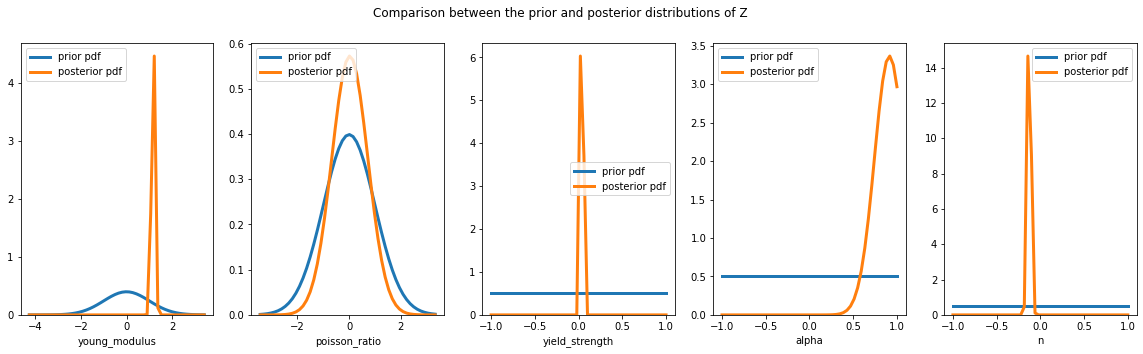

In [88]:
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
fig.suptitle("Comparison between the prior and posterior distributions of Z")

for i, p in enumerate(PARAMETER_NAMES):
    z_min = Z[:, i].min()
    z_max = Z[:, i].max()
    z = np.linspace(z_min, z_max)
    pdf = Z_DISTRIBUTIONS[p].pdf(z)
    pdf_vi = q.marginal_pdf(i, z)
    axes[i].plot(z, pdf, linewidth=3, label="prior pdf")
    axes[i].plot(z, pdf_vi, linewidth=3, label="posterior pdf")
    axes[i].legend()
    axes[i].set_xlabel(p)
    axes[i].set_ylim(bottom=0.0)

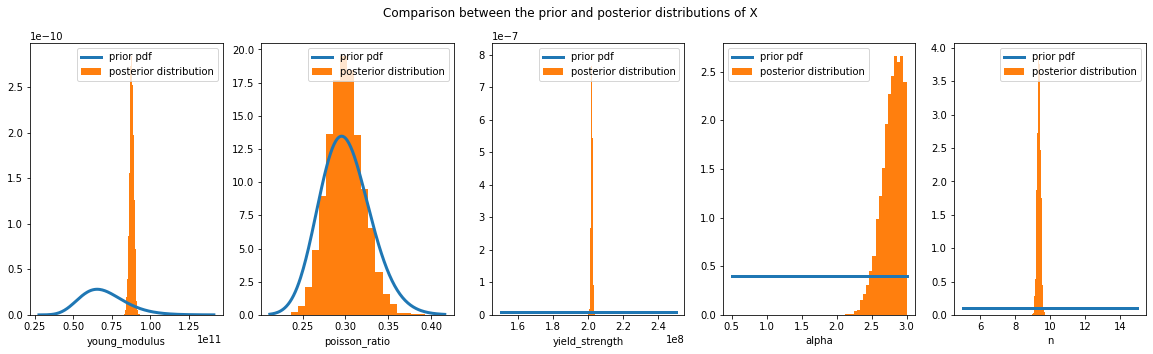

In [89]:
size = 10000
z_vi = q.sample(size)
x_vi = z2x(z_vi)

fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
fig.suptitle("Comparison between the prior and posterior distributions of X")

for i, p in enumerate(PARAMETER_NAMES):
    x_min = X[:, i].min()
    x_max = X[:, i].max()
    x = np.linspace(x_min, x_max, 200)
    pdf = X_DISTRIBUTIONS[p].pdf(x)
    axes[i].plot(x, pdf, linewidth=3, label="prior pdf")
    axes[i].hist(x_vi[:, i], bins=20, density=True, label="posterior distribution")
    axes[i].legend()
    axes[i].set_xlabel(p)
    axes[i].set_ylim(bottom=0.0)

Finally, we can check by drawing samples from the approximation of the predictive posterior distribution $p(Y \mid Y_e=y_e)$.
In order to easily sample from this distribution, one must first sample $z$ from $q(Z) \approx p(Z\mid Y_e=y_e)$, and then
evaluate $Y_{PC}(z)\approx Y(z)$.

Text(0, 0.5, '$\\sigma_{xy}$')

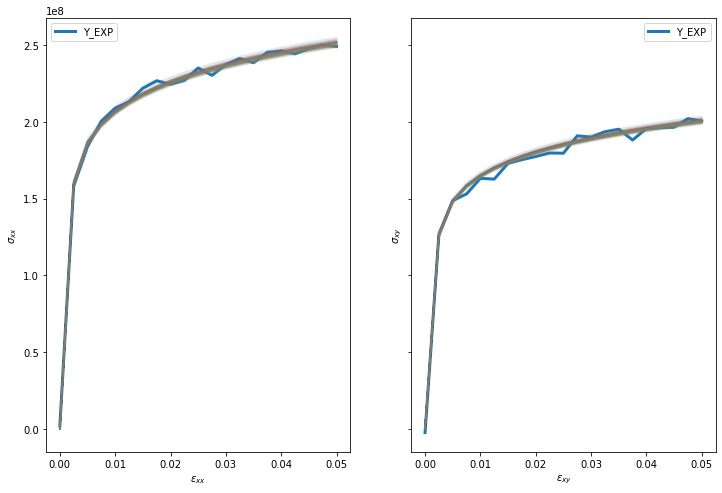

In [90]:
num_curves = 100
z_posterior = q.sample(num_curves)
y_posterior = Y_PC(z_posterior)

strain, tensile_stress, shear_stress = extract_strain_stresses(Y_EXP)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(12, 8))
axes[0].plot(strain, tensile_stress, linewidth=3, label="Y_EXP")
axes[1].plot(strain, shear_stress, linewidth=3, label="Y_EXP")
for i in range(num_curves):
    _, tensile_stress_pred, shear_stress_pred = extract_strain_stresses(y_posterior[i])
    axes[0].plot(strain, tensile_stress_pred, alpha=0.1)
    axes[1].plot(strain, shear_stress_pred, alpha=0.1)

axes[0].legend()
axes[0].set_xlabel(r"$\varepsilon_{xx}$")
axes[0].set_ylabel(r"$\sigma_{xx}$")
axes[1].legend()
axes[1].set_xlabel(r"$\varepsilon_{xy}$")
axes[1].set_ylabel(r"$\sigma_{xy}$")